<a href="https://colab.research.google.com/github/RufusRubin/YOLO_V1/blob/main/XCEPTION_CBAM_YOLO_V1(large_dataset)ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pretrainedmodels
!pip install torchsummary
!pip install imutils
!pip install tqdm

! pip install torchview
! pip install graphviz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=33e4f0e9a9e4a794369df8e68fe1269aadbf6ae4f763a067044b3bd22dcdb4de
  Stored in directory: /root/.cache/pip/wheels/4f/89/a3/5cf59e30a8a75c917c313f14da0f6209be2d147e3160b985d6
Successfully built pretrainedmodels
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=be2f06031bf2d5c6aa29979b8136b068e18066ff0298b829cb03cbb44073ab6c
  Stored in directory: /root/.cache/pip/wheels/35/e4/69/cb99d996d14a2971b79b990d68b05a17d58ce530ff96090dfc
Successfully built imutils


In [ ]:
import random

In [ ]:
import os
from collections import Counter
from tqdm import tqdm
import sys
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models
import pretrainedmodels


from torchview import draw_graph
import graphviz


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from xml.etree import ElementTree as et

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class PotholeDataset(torch.utils.data.Dataset):

    def __init__(self, dir_path,S=7, B=2, C=1, transform=None):

        self.dir_path = dir_path
        self.transform = transform
        self.S = S
        self.C = C
        self.B = B

        self.data= list(sorted(os.listdir(os.path.join(dir_path, "images"))))
        self.annotation= list(sorted(os.listdir(os.path.join(dir_path, "annotations"))))

    def __len__(self):
      return len(self.annotation)


    def __getitem__(self, idx):


        img_path = os.path.join(self.dir_path, "images", self.data[idx])
        ann_path = os.path.join(self.dir_path, "annotations", self.annotation[idx])
        immg_path= os.path.join(self.dir_path, "images")

        #image = Image.open(img_path)


        image = cv2.imread(img_path)
        # convert BGR to RGB color format
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image_resized = cv2.resize(image, (self.width, self.height))
        #image_resized /= 255.0


        labels = []
        boxes = []
        tree = et.parse(ann_path)
        root = tree.getroot()
        
        class_dictionary = {'pothole':0}
        class_dictionary_1 = {'Pothole':0}
        class_dictionary_2 = {'pothole_water':0}
        class_dictionary_3 = {'damage':0}
        class_dictionary_4 = {'crack':0}
        class_dictionary_5 = {'pothole_water_m':0}
                
    
        if(int(root.find('size').find('height').text) != 0):
            filename = root.find('filename').text
            img = Image.open(immg_path + '/' + filename)
            img_width, img_height = img.size
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                
                if(klass== 'pothole'):
                    
                      klass = class_dictionary[klass]
                      #print("True")
                elif(klass=='Pothole'):
                    
                      klass = class_dictionary_1[klass]
                      #print("false")
                    
                elif(klass=='pothole_water'):
                    
                      klass = class_dictionary_2[klass]
                      #print("false")
                    
                    
                elif(klass=='damage'):
                    
                      klass = class_dictionary_3[klass]
                      #print("false")
                    
                elif(klass=='crack'):
                    
                      klass = class_dictionary_4[klass]
                      #print("false")
                    
                else:
                    
                      klass = class_dictionary_5[klass]
                      #print("false")
                    
                    

                    
                    
                    
                    
                    
                    
            
                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])
            
        elif(int(root.find('size').find('height').text) != 0):
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                #klass = class_dictionary[klass]   
                
                    
                if(klass== 'pothole'):
                    
                      klass = class_dictionary[klass]
                      #print("True")
                elif(klass=='Pothole'):
                    
                      klass = class_dictionary_1[klass]
                      #print("false")
                    
                elif(klass=='pothole_water'):
                    
                      klass = class_dictionary_2[klass]
                      #print("false")
                    
                    
                elif(klass=='damage'):
                    
                      klass = class_dictionary_3[klass]
                      #print("false")
                    
                elif(klass=='crack'):
                    
                      klass = class_dictionary_4[klass]
                      #print("false")
                    
                else:
                    
                      klass = class_dictionary_5[klass]
                      #print("false")
                    
                    
                    
            
                                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
                img_width = int(root.find('size').find('width').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                img_height = int(root.find('size').find('height').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])




        boxes = torch.Tensor(boxes)

        if self.transform:
          image, boxes = self.transform(image, boxes)


        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        for box in boxes:
          class_label, x, y, width, height = box
          class_label = int(class_label)
          i, j = int(self.S * y), int(self.S * x)
          x_cell, y_cell = self.S * x - j, self.S * y - i
          width_cell, height_cell = (
              width * self.S,
              height *self.S,
          )

          if label_matrix[i, j, 1] == 0:
            label_matrix[i, j, 1] = 1 
            box_coordinates = torch.Tensor(
                [x_cell, y_cell, width_cell, height_cell]
            )
            label_matrix[i,j, 2:6] = box_coordinates
            label_matrix[i,j, class_label] = 1

          return image, label_matrix

In [ ]:
dataset= PotholeDataset(dir_path='/kaggle/input/dataset-pothole-large/dataset_pothole/train')

In [ ]:
x,y =dataset[0]

In [ ]:
x.shape

(768, 1024, 3)

In [ ]:
y.shape

torch.Size([7, 7, 11])

# **Transform**

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

    
#orginal dataset
orginal_transform = Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
  
])


#for data augmentation

augmentated_transform = Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
  
])

In [ ]:
dataset= PotholeDataset(dir_path='/kaggle/input/dataset-pothole-large/dataset_pothole/train',transform= orginal_transform)

In [ ]:
x,y =dataset[0]

In [ ]:
x.shape

torch.Size([3, 299, 299])

In [ ]:
y.shape

torch.Size([7, 7, 11])

# **IOU**

In [ ]:
def intersection_over_union(boxes_pred, boxes_labels, box_format = "midpoint"):

  if box_format == "midpoint":
    box1_x1 = boxes_pred[..., 0:1] - boxes_pred[..., 2:3]/2
    box1_y1 = boxes_pred[..., 1:2] - boxes_pred[..., 3:4]/2
    box1_x2 = boxes_pred[..., 0:1] + boxes_pred[..., 2:3]/2
    box1_y2 = boxes_pred[..., 1:2] + boxes_pred[..., 3:4]/2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3]/2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4]/2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3]/2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4]/2

  elif box_format == "corners":
    box1_x1 = boxes_pred[..., 0:1]
    box1_y1 = boxes_pred[..., 1:2]
    box1_x2 = boxes_pred[..., 2:3]
    box1_y2 = boxes_pred[..., 3:4]
    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

  x1 = torch.max(box1_x1, box2_x1)
  y1 = torch.max(box1_y1, box2_y1)
  x2 = torch.min(box1_x2, box2_x2)
  y2 = torch.min(box1_y2, box2_y2)

  intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
#   print(intersection)

  box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
  box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

  union  = box1_area + box2_area -intersection

  return intersection/(union + 1e-6)

# **NMS**

In [ ]:
def non_max_suppression(bboxes,iou_threshold,prob_threshold,box_format = "corners"):
  
  assert type(bboxes) == list

  bboxes = [box for box in bboxes if box[1] > prob_threshold]
  bboxes = sorted(bboxes, key=lambda x : x[1], reverse = True)
  bboxes_aft_nms = []

  while bboxes:
    chosen_box = bboxes.pop(0)

    bboxes = [
              box for box in bboxes
              if box[0] != chosen_box[0]
              or intersection_over_union(
                  torch.Tensor(chosen_box[2:]),
                  torch.Tensor(box[2:]),
                  box_format = box_format
              ) < iou_threshold
    ]

    bboxes_aft_nms.append(chosen_box)

  return bboxes_aft_nms

In [ ]:
def convert_cellboxes(predictions, S=7, C=1):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [ ]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

# **VISUALIZE THE IMAGE**

In [ ]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = 'Pothole'
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
      
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        conf = box[1]
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle((upper_left_x * width, upper_left_y * height),box[2] * width,box[3] * height,linewidth=2,edgecolor=colors[int(class_pred)],facecolor="none")
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(upper_left_x,upper_left_y ,s=class_labels[int(class_pred)] + ': ' + str(conf),color="white",verticalalignment="top",bbox={"color": colors[int(class_pred)], "pad": 0})

    plt.show()

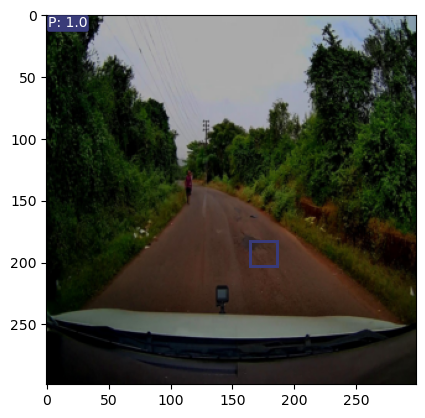

In [ ]:
S = [7]
dataset= PotholeDataset(dir_path='/kaggle/input/dataset-pothole-large/dataset_pothole/test', transform= orginal_transform)
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
for x, y in loader:
    boxes = []

    for i in range(y[0].shape[1]):

        boxes+= cellboxes_to_boxes(y)[0]
    boxes = non_max_suppression(boxes, iou_threshold=1, prob_threshold=0.7,  box_format="midpoint")
    plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
    #area_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
    break


# **YOLO LOSS**

In [ ]:
class yololoss(nn.Module):
  def __init__(self, S = 7, B = 2, C = 1):
    super(yololoss, self).__init__()
    self.mse = nn.MSELoss(reduction="sum")
    self.S = S
    self.B = B
    self.C = C
    self.lambda_coord = 5
    self.lambda_noobj = 0.5

  def forward(self, prediction, target):
    prediction = prediction.reshape(-1, self.S, self.S, self.C + self.B * 5)
#     print(prediction.shape)

    iou_b1 = intersection_over_union(prediction[...,2:6], target[...,2:6])
    iou_b2 = intersection_over_union(prediction[...,7:11], target[...,2:6])

    ious = torch.cat([iou_b1.unsqueeze(0),iou_b2.unsqueeze(0)], dim =0)
    iou_maxes, best_box = torch.max(ious, dim=0)
    exists_box = target[..., 1].unsqueeze(3) #Iobj_i
    
    if torch.sum(best_box) > 1:
        best_box = 1
    else:
        best_box = 0
    ####  BOX LOSS  ####
    #Box-Coordinates (mid-point, width & height)
    box_predictions = exists_box * (
        (
            best_box * prediction[...,7:11]
            + (1 - best_box) * prediction[...,2:6]
        )
    )

    box_targets = exists_box * target[...,2:6]

    box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
        torch.abs(box_predictions[..., 2:4] + 1e-6)
    )
    
    #box dimensions: (N, S, S, 6)
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
    #(N, S, S, 4) -> (N*S*S, 4)
    box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2),
                        torch.flatten(box_targets, end_dim=-2),
                        )
    
    #### OBJECT LOSS ####
    pred_box = (
        best_box * prediction[..., 6:7] + (1 - best_box) * prediction[...,1:2]
    )
    # (N,S,S,1) -> (N*S*S*1)
    object_loss = self.mse(
        torch.flatten(exists_box * pred_box),
        torch.flatten(exists_box * target[...,1:2])
    )

    #### NO-OBJECT LOSS ####
    #(N, S, S, 1) -> (N, S*S*1)
    no_object_loss = self.mse(
        torch.flatten((1 - exists_box) * prediction[..., 1:2], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 1:2], start_dim=1),
    )

    no_object_loss = self.mse(
        torch.flatten((1 - exists_box) * prediction[..., 6:7], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 1:2], start_dim=1),
    )

    class_loss = self.mse(
        torch.flatten(exists_box * prediction[...,:1], end_dim = -2),
        torch.flatten(exists_box * target[...,:1], end_dim = -2)
    )

    loss = (
        self.lambda_coord * box_loss 
        + object_loss
        + self.lambda_noobj * no_object_loss
        + class_loss
    )

    return loss


# **MAP**

In [ ]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold = 0.5, box_format="corners", num_classes=1):

  #pred_boxes_format = [[train_id, class_prob, box_prob, x1, y1, x2, y2], ...]
  average_precisions = []
    
  epsilon = 1e-6

  for c in range(num_classes):
    detections = []
    ground_truths = []

    for detection in pred_boxes:
      if detection[1] == c:
        detections.append(detection)

    for true_box in true_boxes:
      if true_box[1] == c:
        ground_truths.append(true_box)

    amount_boxes = Counter([gt[0] for gt in ground_truths])
    
    for key, val in amount_boxes.items():
      amount_boxes[key] = torch.zeros(val)

    detections.sort(key = lambda x: x[2], reverse = True)
    TP = torch.zeros((len(detections)))
    FP = torch.zeros((len(detections)))
    total_true_bboxes = len(ground_truths)

    for detection_idx, detection in enumerate(detections):
      ground_truth_img = [
              bbox for bbox in ground_truths  if bbox[0] == detection[0]
                   ]

      num_gts = len(ground_truth_img)
      best_iou = 0

      for idx, gt in enumerate(ground_truth_img):
        iou = intersection_over_union(
            torch.Tensor(detection[3:]),
            torch.Tensor(gt[3:]),
            box_format = box_format,
            )
        
        if iou > best_iou:
          best_iou = iou
          best_gt_idx = idx

      if best_iou > iou_threshold:

        if amount_boxes[detection[0]][best_gt_idx] == 0:
            TP[detection_idx] = 1
            amount_boxes[detection[0]][best_gt_idx] = 1
        else:
            FP[detection_idx] = 1
       
      else:
        FP[detection_idx] = 1 

    TP_cumsum = torch.cumsum(TP, dim=0)
    FP_cumsum = torch.cumsum(FP, dim=0)
    recalls = TP_cumsum / (total_true_bboxes + epsilon)
    precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
    precisions = torch.cat((torch.tensor([1]), precisions))
    recalls = torch.cat((torch.tensor([0]), recalls))
    average_precisions.append(torch.trapz(precisions, recalls))

  return sum(average_precisions) / len(average_precisions), sum(average_precisions)



# **GET_BBOXES**

In [ ]:
def get_bboxes(loader,model,iou_threshold,threshold,pred_format="cells",box_format="midpoint",device=device):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                prob_threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

# **YOLO-V1 MODEL**

In [ ]:
!pip install timm

In [ ]:
import timm
original_model= timm.create_model('xception', pretrained=True).to(device)
print(original_model)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [ ]:
class xception(nn.Module):
    def __init__(self, pretrained,split_size, num_boxes, num_classes):
        super(xception, self).__init__()
        
        S, B, C = split_size, num_boxes, num_classes
        
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
        
#       #################################################################################################

        # spatial attention
        self.spatial_attention = torch.nn.Sequential(
            torch.nn.Conv2d(2, 1, kernel_size=7, padding=3, stride=1),
            torch.nn.BatchNorm2d(1),
            torch.nn.Sigmoid()
        )


        ########################################################################################################


        # channel attention
        self.max_pool_1 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size= 8, stride= 8))


        self.avg_pool_1 = torch.nn.Sequential(torch.nn.AvgPool2d(kernel_size= 8, stride= 8))



        ##########################################################################################################################

        self.avgpool= nn.AdaptiveAvgPool2d((7,7))
        self.flatten= nn.Flatten()
        self.linear_1= nn.Linear(2048 * S * S, 512)
        self.dropout= nn.Dropout(0.0)
        self.leakyrelu= nn.LeakyReLU(0.1)
        self.linear_2= nn.Linear(512, S * S *(C + B * 5))
        
        
        
    def forward(self, x):
        # get the batch size only, ignore(c, h, w)
        x = self.features(x)
        
        scale = torch.nn.functional.sigmoid(self.max_pool_1(x) + self.avg_pool_1(x)).expand_as(x)
        x = x * scale
        scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
        scale = self.spatial_attention(scale)
        x = x * scale
        
        
        x=self.avgpool(x)
        x= self.flatten(x)
        x=self.linear_1(x)
        x=self.dropout(x)
        x=self.leakyrelu(x)
        x=self.linear_2(x)
        
        return x

In [ ]:
model = xception(pretrained=True,split_size = 7, num_boxes=2, num_classes = 1).to(device)
print(model)

xception(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): S

In [ ]:
model = xception(pretrained=True,split_size = 7, num_boxes=2, num_classes = 1).to(device)
summary(model, (3, 299, 299))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 64, 147, 147]          18,432
       BatchNorm2d-5         [-1, 64, 147, 147]             128
              ReLU-6         [-1, 64, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]             576
            Conv2d-8        [-1, 128, 147, 147]           8,192
   SeparableConv2d-9        [-1, 128, 147, 147]               0
      BatchNorm2d-10        [-1, 128, 147, 147]             256
             ReLU-11        [-1, 128, 147, 147]               0
           Conv2d-12        [-1, 128, 147, 147]           1,152
           Conv2d-13        [-1, 128, 147, 147]          16,384
  SeparableConv2d-14        [-1, 128, 1

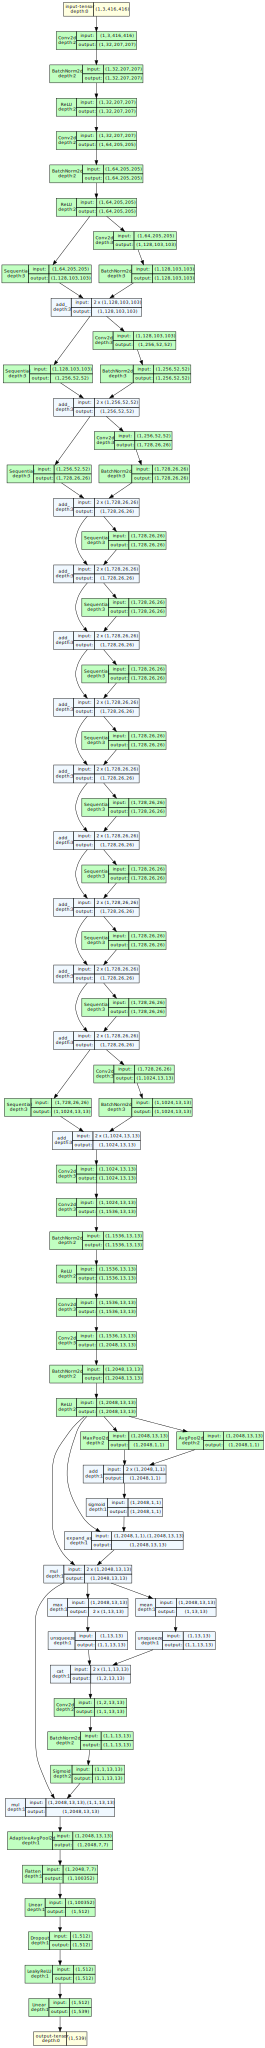

In [ ]:
model_plot = draw_graph(model, input_size=(1,3,416,416))
model_plot.visual_graph

In [ ]:
def test(S = 7, B = 2, C = 1):
  model = xception(pretrained=True,split_size = S, num_boxes=B, num_classes = C).to(device)
  x = torch.randn((1, 3, 299, 299)).to(device)
  print(model(x).shape)

test()


torch.Size([1, 539])


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# **OPTIMIZER AND LOSS**

In [ ]:
lr = 0.0001
BATCH_SIZE = 8
WEIGHT_DECAY = 0.00005
save_path = "xception_yolo_v1.pth"
fine_tune = True
load_path = "/kaggle/input/xception-yolo-v1-weight/xception_yolo_v1.pth"

In [ ]:
loss_fn = yololoss()

model = xception(pretrained=True,split_size = 7, num_boxes=2, num_classes = 1).to(device)

#optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=WEIGHT_DECAY)

optimizer= optim.SGD(model.parameters(), lr= lr, momentum= 0.9, weight_decay=WEIGHT_DECAY)

#optimizer= optim.RMSprop(model.parameters(), lr= lr, momentum= 0.9, weight_decay=WEIGHT_DECAY)


# **WEIGHT LOADING**

In [ ]:
state_dict = torch.load(load_path, map_location=device)
model.load_state_dict(state_dict, strict= False)

_IncompatibleKeys(missing_keys=['spatial_attention.0.weight', 'spatial_attention.0.bias', 'spatial_attention.1.weight', 'spatial_attention.1.bias', 'spatial_attention.1.running_mean', 'spatial_attention.1.running_var'], unexpected_keys=[])

# **TRAINING FUNCTION**

In [ ]:
def train(model,dataloader):    
    # training function

    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):


        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()



    loss = running_loss/len(dataloader)

    print('Train Loss: %.3f'%(loss))

    return loss


# **VALIDATION FUNCTION**

In [ ]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss_fn(pred, y).item()        

        
        loss = running_loss/len(dataloader.dataset)

        print('Test Loss: %.3f '%(loss))
        
        return loss 

# **LOAD DATA**

In [ ]:
orginal_train_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole-large/dataset_pothole/train',transform = orginal_transform)

augmented_train_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole-large/dataset_pothole/train', transform = augmentated_transform)

train_data = torch.utils.data.ConcatDataset([orginal_train_dataset,augmented_train_dataset])

print(len(train_data))


orginal_test_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole-large/dataset_pothole/test', transform = orginal_transform)

augmented_test_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole-large/dataset_pothole/test',transform = augmentated_transform)

test_data = torch.utils.data.ConcatDataset([orginal_test_dataset,augmented_test_dataset])

print(len(test_data))

3500
198


# **DATA LOADER**

In [ ]:
train_loader = DataLoader(dataset = train_data,batch_size = BATCH_SIZE,shuffle=True,num_workers=4,drop_last = True, pin_memory= True)

test_loader = DataLoader(dataset = test_data,batch_size = BATCH_SIZE,shuffle=True, num_workers=4, drop_last = True,  pin_memory= True)



/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
epochs= 50



train_loss , val_loss = [], []





print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")


for epoch in range(epochs):
    
      print(f"Epoch {epoch+1} of {epochs}")

      # training

      train_epoch_loss = train(model, train_loader)
      train_loss.append(train_epoch_loss)

      #validation


      val_epoch_loss = validate(model, test_loader)
      val_loss.append(val_epoch_loss)




Training on 3500 examples, validating on 198 examples...
Epoch 1 of 50
Training


100%|██████████| 437/437 [01:47<00:00,  4.07it/s]

Train Loss: 2.629
Validating


Test Loss: 0.043 
Epoch 2 of 50
Training


100%|██████████| 437/437 [01:50<00:00,  3.97it/s]

Train Loss: 1.804
Validating


Test Loss: 0.037 
Epoch 3 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 1.393
Validating


Test Loss: 0.029 
Epoch 4 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 1.161
Validating


Test Loss: 0.030 
Epoch 5 of 50
Training


100%|██████████| 437/437 [01:50<00:00,  3.97it/s]

Train Loss: 0.995
Validating


Test Loss: 0.024 
Epoch 6 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 1.036
Validating


Test Loss: 0.026 
Epoch 7 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 0.788
Validating


Test Loss: 0.041 
Epoch 8 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.97it/s]

Train Loss: 1.146
Validating


Test Loss: 0.026 
Epoch 9 of 50
Training


100%|██████████| 437/437 [01:50<00:00,  3.96it/s]

Train Loss: 0.649
Validating


Test Loss: 0.024 
Epoch 10 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.698
Validating


Test Loss: 0.022 
Epoch 11 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.774
Validating


Test Loss: 0.026 
Epoch 12 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 0.615
Validating


Test Loss: 0.027 
Epoch 13 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.779
Validating


Test Loss: 0.025 
Epoch 14 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 0.602
Validating


Test Loss: 0.026 
Epoch 15 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.486
Validating


Test Loss: 0.025 
Epoch 16 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.463
Validating


Test Loss: 0.023 
Epoch 17 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.450
Validating


Test Loss: 0.025 
Epoch 18 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 0.434
Validating


Test Loss: 0.023 
Epoch 19 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.422
Validating


Test Loss: 0.024 
Epoch 20 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.407
Validating


Test Loss: 0.023 
Epoch 21 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.396
Validating


Test Loss: 0.024 
Epoch 22 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.390
Validating


Test Loss: 0.025 
Epoch 23 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 0.380
Validating


Test Loss: 0.022 
Epoch 24 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.373
Validating


Test Loss: 0.024 
Epoch 25 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 0.366
Validating


Test Loss: 0.024 
Epoch 26 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.365
Validating


Test Loss: 0.022 
Epoch 27 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 0.353
Validating


Test Loss: 0.023 
Epoch 28 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.341
Validating


Test Loss: 0.022 
Epoch 29 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 0.336
Validating


Test Loss: 0.024 
Epoch 30 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.328
Validating


Test Loss: 0.023 
Epoch 31 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.329
Validating


Test Loss: 0.024 
Epoch 32 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 0.320
Validating


Test Loss: 0.023 
Epoch 33 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.315
Validating


Test Loss: 0.023 
Epoch 34 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.310
Validating


Test Loss: 0.022 
Epoch 35 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.303
Validating


Test Loss: 0.023 
Epoch 36 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.297
Validating


Test Loss: 0.023 
Epoch 37 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.296
Validating


Test Loss: 0.023 
Epoch 38 of 50
Training


 72%|███████▏  | 316/437 [01:19<00:32,  3.72it/s]

Test Loss: 0.022 
Epoch 40 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.284
Validating


Test Loss: 0.024 
Epoch 41 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.280
Validating


Test Loss: 0.023 
Epoch 42 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.276
Validating


Test Loss: 0.024 
Epoch 43 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.273
Validating


Test Loss: 0.023 
Epoch 44 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.98it/s]

Train Loss: 0.268
Validating


Test Loss: 0.023 
Epoch 45 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.270
Validating


Test Loss: 0.022 
Epoch 46 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.265
Validating


Test Loss: 0.023 
Epoch 47 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.265
Validating


Test Loss: 0.024 
Epoch 48 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.259
Validating


Test Loss: 0.024 
Epoch 49 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  3.99it/s]

Train Loss: 0.257
Validating


Test Loss: 0.023 
Epoch 50 of 50
Training


100%|██████████| 437/437 [01:49<00:00,  4.00it/s]

Train Loss: 0.253
Validating


Test Loss: 0.023 


In [ ]:
torch.save(model.state_dict(), save_path)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = xception(pretrained=True,split_size = 7, num_boxes=2, num_classes = 1).to(device)
state_dict = torch.load(f"/kaggle/working/{save_path}")
model.load_state_dict(state_dict)


<All keys matched successfully>

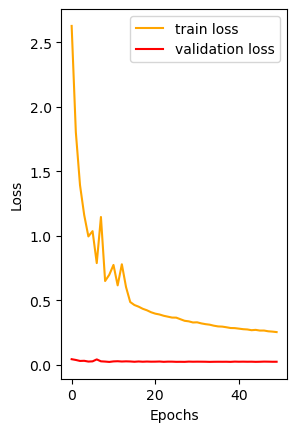

In [ ]:
# loss plots
plt.subplot(122)
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/plots/loss.png')
plt.show()


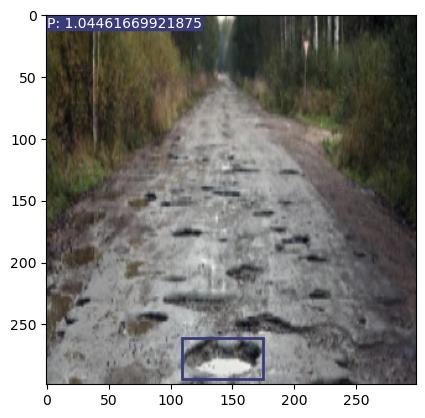

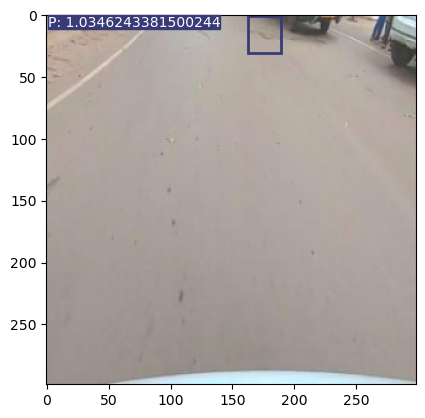

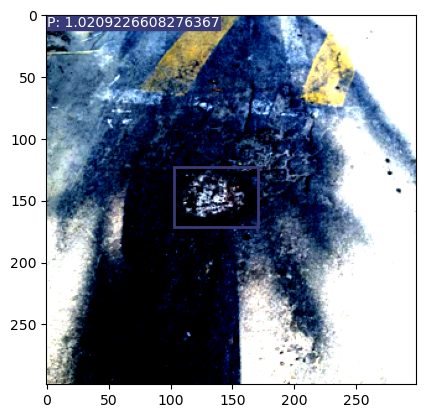

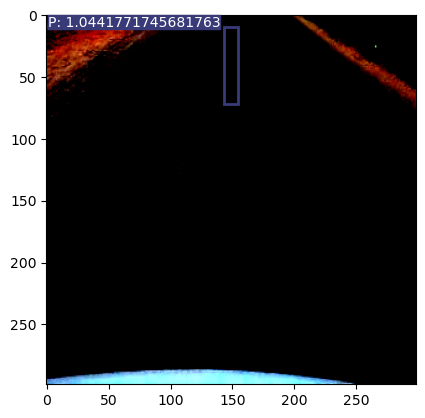

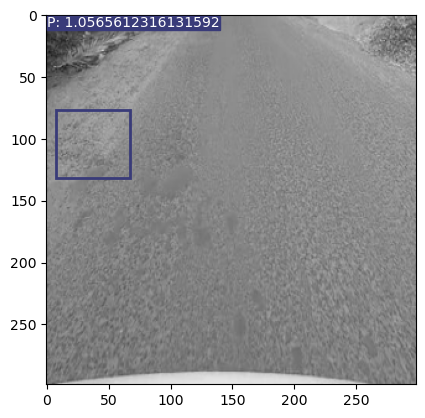

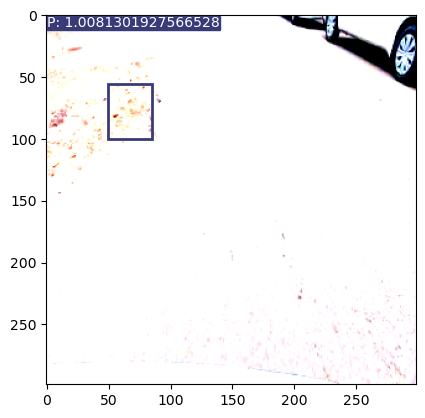

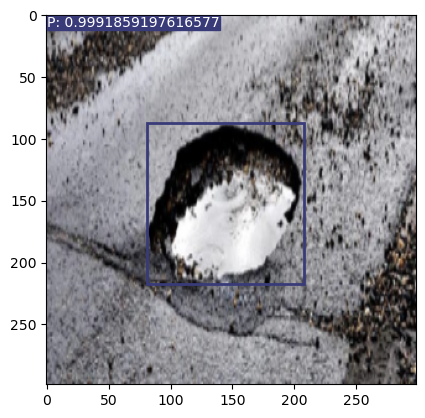

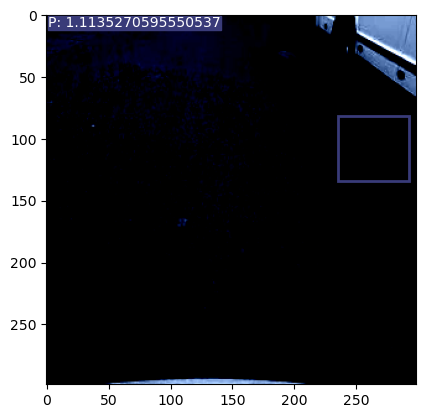

SystemExit: 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
for epoch in range(4):
    for x, y in train_loader:
       x = x.to(device)
       for idx in range(8):
           bboxes = cellboxes_to_boxes(model(x))
           bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, prob_threshold=0.4, box_format="corners")
           plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
           #area_image(x[idx].permute(1, 2, 0).to("cpu"), bboxes)

       import sys
       sys.exit()

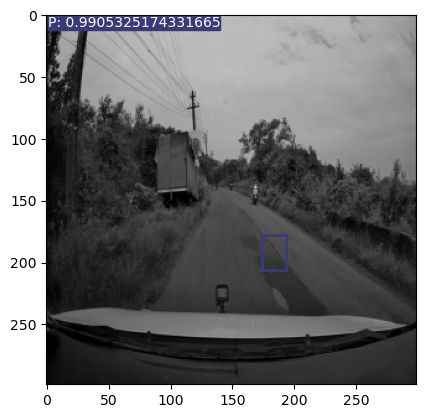

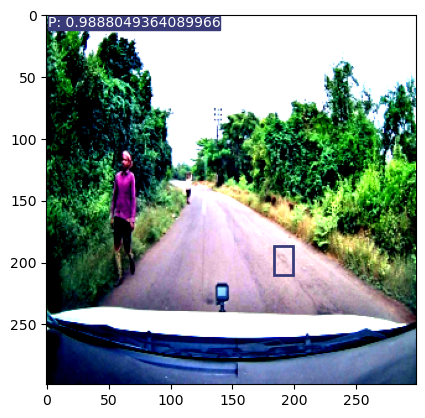

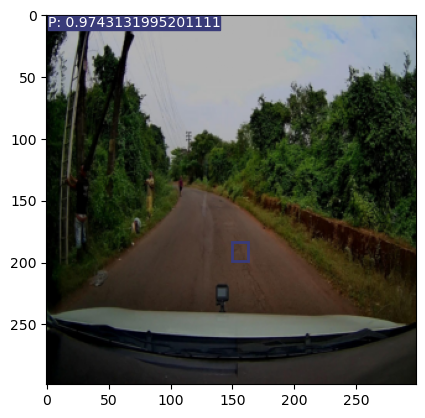

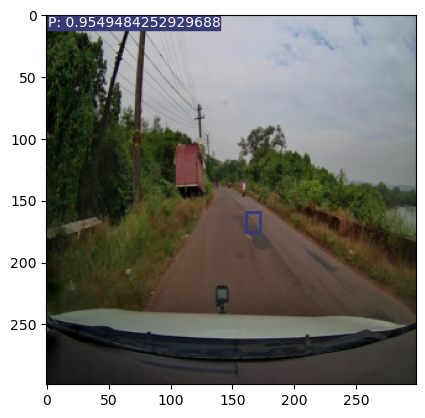

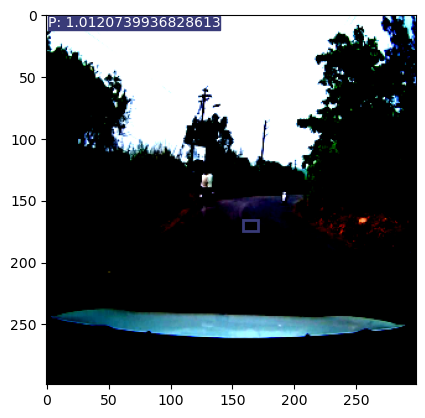

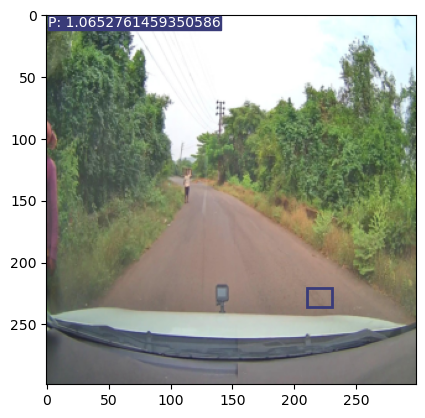

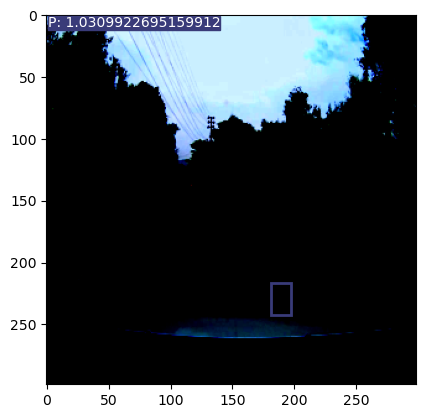

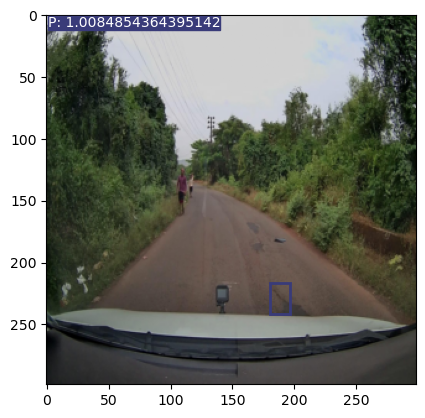

SystemExit: 

In [ ]:
for epoch in range(4):
    for x, y in test_loader:
       x = x.to(device)
       for idx in range(8):
           bboxes = cellboxes_to_boxes(model(x))
           bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, prob_threshold=0.4, box_format="corners")
           plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
           #area_image(x[idx].permute(1, 2, 0).to("cpu"), bboxes)

       import sys
       sys.exit()

# **TRAIN & VAL MAP**

In [ ]:

pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)
mean_avg_prec, average_precisions = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Train mAP: {mean_avg_prec}")
print(f"Train average_precisions: {average_precisions}")


pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4)
mean_avg_prec, average_precisions = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Val mAP: {mean_avg_prec}")
print(f"Val average_precisions: {average_precisions}")

Train mAP: 0.9904984831809998
Train average_precisions: 0.9904984831809998
Val mAP: 0.9739583134651184
Val average_precisions: 0.9739583134651184


# **TEST MAP**

In [ ]:

test_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole-large/dataset_pothole/test', transform = orginal_transform)

test_loader = DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE,shuffle=True,drop_last = True)

pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4)


mean_avg_prec, average_precisions = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Test mAP: {mean_avg_prec}")
print(f"Test average_precisions: {average_precisions}")

Test mAP: 0.96875
Test average_precisions: 0.96875
